In [3]:
import sys
sys.path.append("..")

from src.evaluate import SECQueryEvaluator

evaluator = SECQueryEvaluator(use_docker=True, verbose=True)

results = evaluator.evaluate_query("What are the main risks for Tesla in 2020?")

print(results)

🔧 Initializing vector store (Docker)...
🐳 Using Docker Qdrant at localhost:6333
✅ Docker connection successful, found 2 collections
📊 Vector store status: {'mode': 'docker', 'collection_name': 'sec_filings', 'model': 'text-embedding-3-small', 'dimensions': 1536, 'docker': {'connected': True, 'collections_count': 2, 'error': None}, 'points_count': 15079}

🔍 Processing query: 'What are the main risks for Tesla in 2020?'
1️⃣ Parsing query...
Parsed query: {'ticker': 'TSLA', 'fiscal_year': 2020, 'sections': ['1A']}
   Parsed parameters: {'ticker': 'TSLA', 'fiscal_year': 2020, 'sections': ['1A']}
2️⃣ Searching for relevant chunks...
   Found 10 chunks
   Top score: 0.655
3️⃣ Generating answer...
   Generated answer (674 chars)

✅ Query processed successfully!
   Total tokens: 2144
   Total cost: $0.0004
   Processing time: 4.57s
{'query': 'What are the main risks for Tesla in 2020?', 'answer': 'The main risks for Tesla in 2020 include challenges in managing growth effectively, which could h

In [4]:
from datasets import load_dataset

ds = load_dataset("virattt/financial-qa-10K")
ds

/Users/jon/GitHub/dowjones-takehome/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [9]:
df_answers = ds['train'].to_pandas()
df_answers.head()

,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",NVDA,2023_10K
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,NVDA,2023_10K
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...,NVDA,2023_10K
3,How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,"NVIDIA has a platform strategy, bringing toget...",NVDA,2023_10K
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,With our introduction of the CUDA programming ...,NVDA,2023_10K


In [10]:
df_answers['filing'].unique()

array(['2023_10K'], dtype=object)

In [14]:
import pandas as pd
df_filings = pd.read_csv('../data/df_filings.csv')

In [16]:
df_filings['fiscal_year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 1999, 1998,
       1996, 1995, 1994, 1993])

In [29]:
import ast 
def format_report(report_str):
    """
    Convert a string representation of a report dictionary into a formatted text report.
    
    Args:
        report_str (str): String representation of a dictionary containing report sections and sentences
        
    Returns:
        str: Formatted report text with section headers and sentences
    """
    report_dict = ast.literal_eval(report_str)
    formatted_report = ""
    
    for section, sentences in report_dict.items():
        header = f"{'-'*25} {section} {'-'*25}"
        formatted_report += f"{header}\n"
        for sentence in sentences:
            formatted_report += f"{sentence}\n"
            
    return formatted_report

# Example usage:
df_filings['formatted_report'] = df_filings['report'].apply(format_report)

In [ ]:
from filing_exploder import FilingExploder
from src.chunkers import SmartChunker
exploder   = FilingExploder()
chunker    = SmartChunker(target_tokens=350, hard_ceiling=800, overlap_tokens=50)

df_filings = df_filings[df_filings['fiscal_year'].between(2012, 2019)]
df_filings_exploded = exploder.explode(df=df_filings)
chunks = chunker.run(df_filings_exploded)
for i in chunks[:5]:
    print(i)
    print("-"*50)

Chunk(id='META_2019_1_0', text='Item 1 – Business Overview: Item 1.Business Overview Our mission is to give people the power to build community and bring the world closer together. We build useful and engaging products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and in-home devices. We also help people discover and learn about what is going on in the world around them, enable people to share their opinions, ideas, photos and videos, and other activities with audiences ranging from their closest family members and friends to the public at large, and stay connected everywhere by accessing our products, including: • Facebook. Facebook enables people to connect, share, discover, and communicate with each other on mobile devices and personal computers. There are a number of different ways to engage with people on Facebook, including News Feed, Stories, Marketplace, and Watch. Instagram. Instagram bring

In [60]:
df_filings_exploded['ticker'].value_counts(

ticker
META    160
AAPL    160
NVDA    160
TSLA    158
Name: count, dtype: int64

In [59]:
# count tokens in a chunk
import tiktoken

tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

for i in range(10):
    print(len(tokenizer.encode(chunks[i].text)))

328
338
336
346
348
322
348
346
252
144


# Evaluation

We're going to generate a labeled QA dataset by feeding our chunked texts into an LLM and having it generate question-answer pairs. We'll utilize `Langchain`'s functionality for this. 

## EDA

First we'll reload our chunked dataframe, and ensure we have an even dataset. 

In [91]:
from filing_exploder import FilingExploder
from src.chunkers import SmartChunker
exploder   = FilingExploder()
chunker    = SmartChunker(target_tokens=350, hard_ceiling=800, overlap_tokens=50)

df_filings = df_filings[df_filings['fiscal_year'].between(2012, 2019)]
df_filings_exploded = exploder.explode(df=df_filings)
df_filings_exploded['tokens'] = df_filings_exploded['text'].apply(lambda x: len(tokenizer.encode(x)))
chunks = chunker.run(df_filings_exploded)
#save chunks to data/chunks.pkl
import pickle
from pathlib import Path
import os

data_dir = Path(os.getcwd()).parent / "data"

# Save chunks to pickle file
with open(data_dir / "chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)

print(f"✅ Saved {len(chunks)} chunks to data/chunks.pkl")


✅ Saved 7523 chunks to data/chunks.pkl


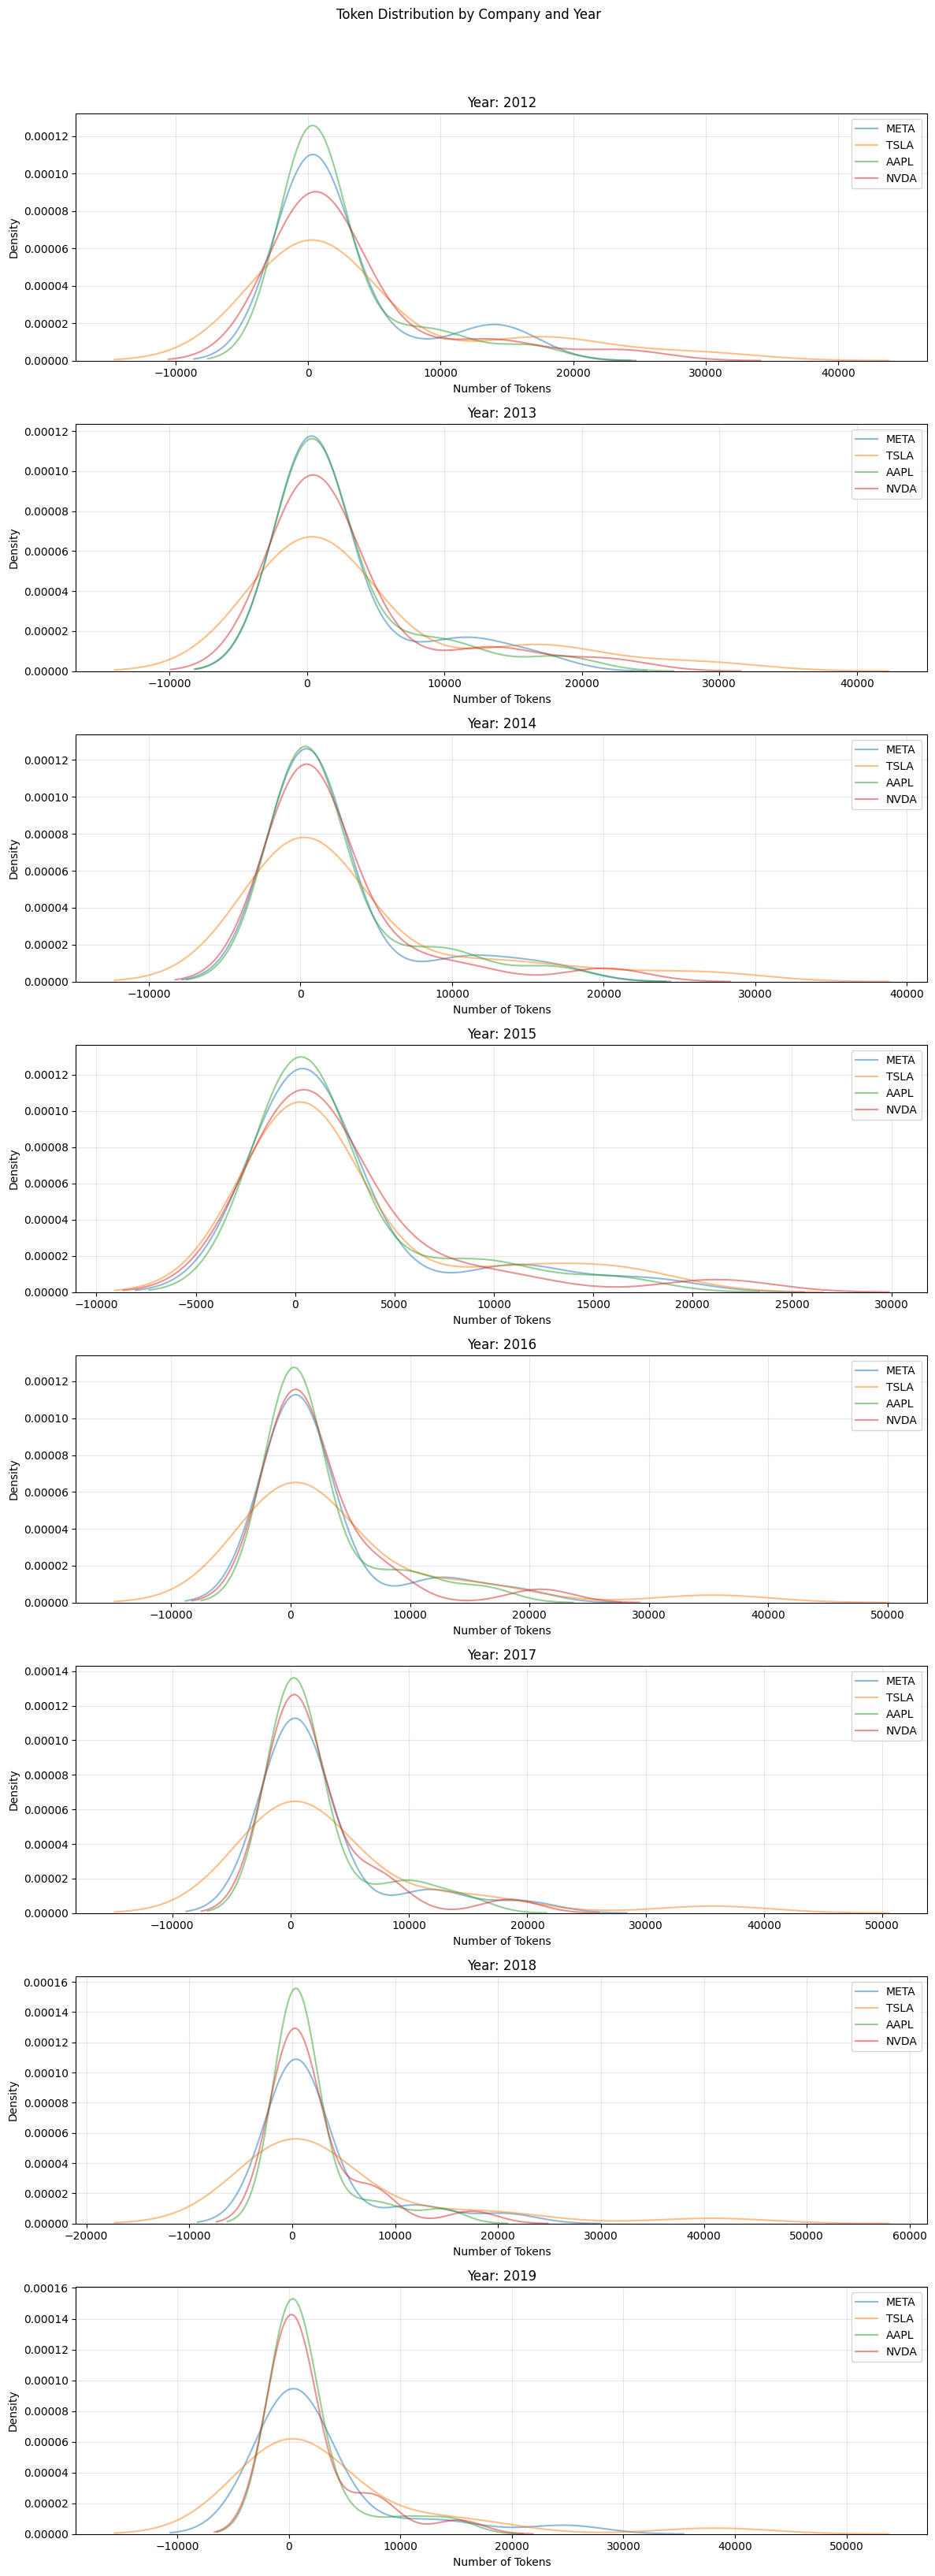

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
# plt.style.use('seaborn')

# Get unique years
years = sorted(df_filings_exploded['fiscal_year'].unique())

# Create subplots for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)))
fig.suptitle('Token Distribution by Company and Year', y=1.02)

# Plot distribution for each year
for idx, year in enumerate(years):
    year_data = df_filings_exploded[df_filings_exploded['fiscal_year'] == year]
    
    # Plot distribution for each company in this year
    for ticker in year_data['ticker'].unique():
        data = year_data[year_data['ticker'] == ticker]['tokens']
        sns.kdeplot(data=data, label=ticker, alpha=0.5, ax=axes[idx])
    
    axes[idx].set_title(f'Year: {year}')
    axes[idx].set_xlabel('Number of Tokens')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Distributions are off. Looks like TSLA tends to have much longer SEC filings, while AAPL has quite short ones. 

In [71]:
df_filings_exploded['ticker'].value_counts()

ticker
META    160
AAPL    160
NVDA    160
TSLA    158
Name: count, dtype: int64

The number of sections is still evenly distributed. What about the distribution of the sections available in each report?

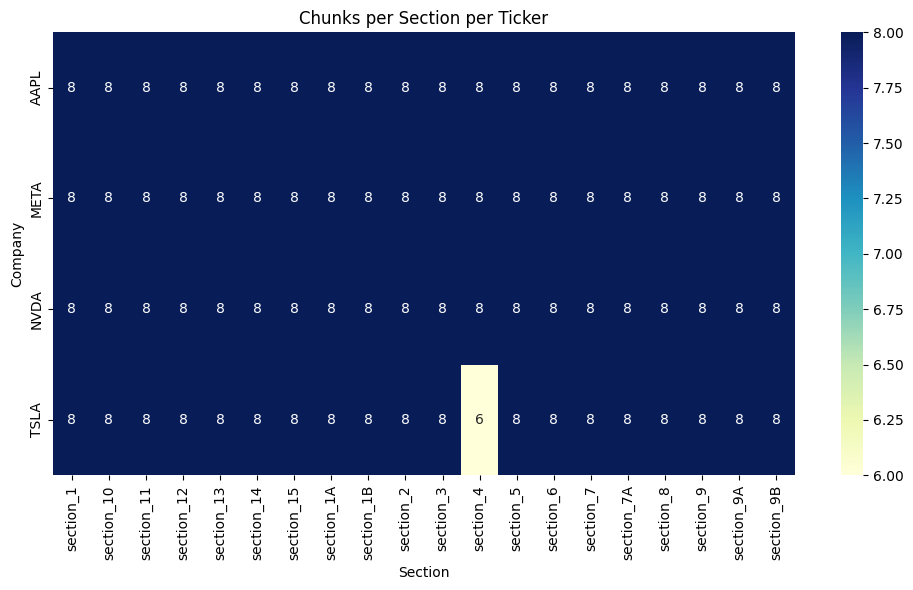

In [74]:
section_balance = (
    df_filings_exploded
    .groupby(["ticker", "section"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)


plt.figure(figsize=(10, 6))
sns.heatmap(section_balance, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Chunks per Section per Ticker")
plt.ylabel("Company")
plt.xlabel("Section")
plt.tight_layout()
plt.show()


So they all have the same amount of sections, except TSLA in section 4. Let's compare the number of tokens per section. 

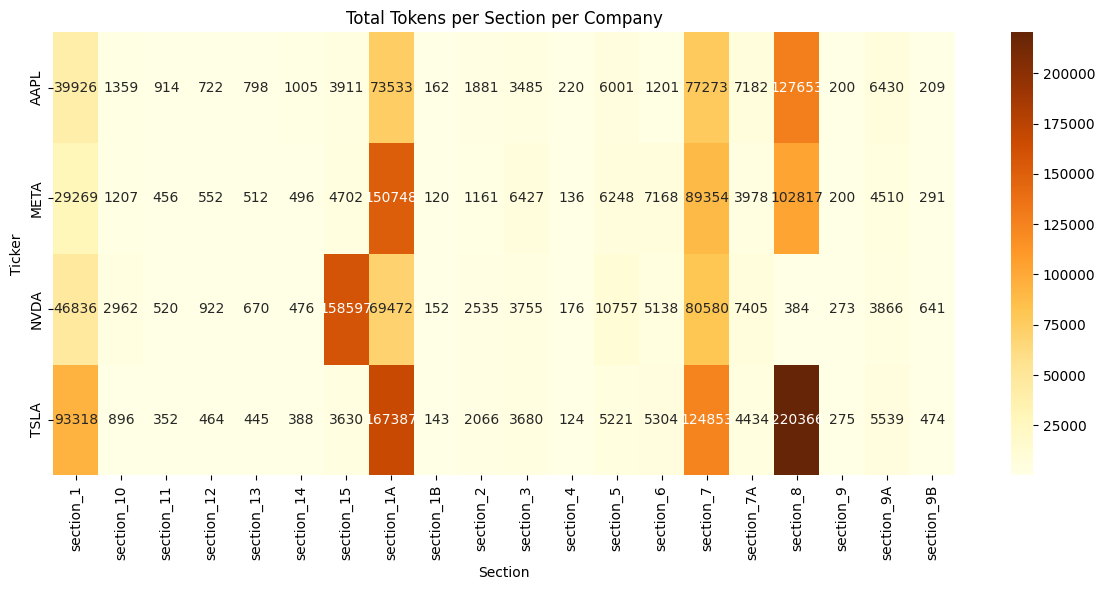

In [77]:
token_matrix = (
    df_filings_exploded
    .groupby(["ticker", "section"])["tokens"]
    .sum()
    .unstack(fill_value=0)
)
plt.figure(figsize=(12, 6))
sns.heatmap(token_matrix, annot=True, fmt="d", cmap="YlOrBr")
plt.title("Total Tokens per Section per Company")
plt.xlabel("Section")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()


Looks like there's some class imbalance we should normalize against. TSLA consistently has longer SEC filings, but are the chunks consistently approaching our hard upper limit of 850 tokens? Let's see how chunks per company are greater than 500 tokens. 

In [81]:

# Assume `chunks` is your list of Chunk objects
chunk_records = []
for idx, c in enumerate(chunks):
    token_count = len(tokenizer.encode(c.text))
    chunk_records.append({
        "idx": idx,
        "ticker": c.metadata["ticker"],
        "year": c.metadata["fiscal_year"],
        "section": c.metadata["item"],
        "token_count": token_count
    })

df_chunks = pd.DataFrame(chunk_records)
df_chunks.head()

,idx,ticker,year,section,token_count
0,0,META,2019,1,328
1,1,META,2019,1,338
2,2,META,2019,1,336
3,3,META,2019,1,346
4,4,META,2019,1,348


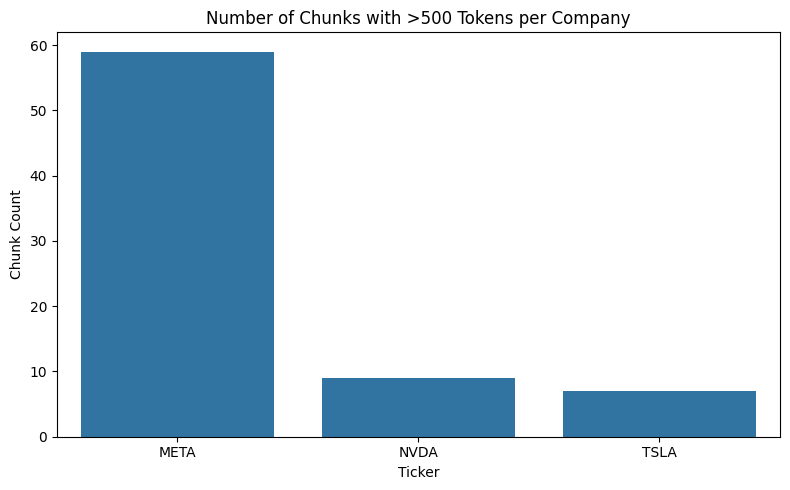

In [86]:
df_chunks["chunk_class"] = pd.cut(
    df_chunks["token_count"],
    bins=[0, 500, 850, float("inf")],
    labels=["short", "medium", "extra_large"]
)

df_long = df_chunks[df_chunks["token_count"] > 500]

plt.figure(figsize=(8, 5))
sns.countplot(data=df_long, x="ticker", order=df_long["ticker"].value_counts().index)
plt.title("Number of Chunks with >500 Tokens per Company")
plt.ylabel("Chunk Count")
plt.xlabel("Ticker")
plt.tight_layout()
plt.show()


Alright so this is what we see about the dataset:
- Sections are more or less equally represented amongst the companies. 
- Lengths of sections are not necessarily equally represented (e.g. NVDA has section 15s that are much longer than the other companies)
- META in general has many more long chunks than NVDA or TSLA. 

In order to make sure our evaluation set is unbiased, we'll do the following:
- **Stratify sampling across key dimensions**. We'll ensure balanced representation across company, year, section, and chunk class (short, medium, extra_large).
- **Downsample overrepresented long chunks**. Each company will contribute an equal number of long chunks to prevent verbosity from dominating QA coverage.
- **Limit QA pairs per group**. Each `(company, year, section, chunk_class)` group will be capped to a consistent number of QA pairs to enforce balance.



## Generate QA dataset

In [ ]:

import pickle
from pathlib import Path
from evaluation.normalize_qa_sample import BalancedChunkSampler, generate_qa_pairs, classify_chunk_by_tokens
from collections import Counter

# Load chunks
try:
    with open("./data/chunks.pkl", "rb") as f:
        chunks = pickle.load(f)
    print(f"📊 Loaded {len(chunks)} chunks")
except FileNotFoundError:
    print("❌ chunks.pkl not found. Make sure the file exists.")
    exit(1)

# Create balanced sample
sampler = BalancedChunkSampler(max_per_group=5, balance_companies=True)
grouped = sampler.group_chunks_by_keys(chunks)
balanced_chunks = sampler.stratified_sample(grouped)

print(f"📊 Balanced sample: {len(balanced_chunks)} chunks from {len(grouped)} groups")

# Show final distribution
company_dist = Counter(chunk.metadata["ticker"] for chunk in balanced_chunks)
chunk_class_dist = Counter(classify_chunk_by_tokens(chunk.text) for chunk in balanced_chunks)

print(f"📈 Final distribution:")
print(f"   By company: {dict(company_dist)}")
print(f"   By chunk class: {dict(chunk_class_dist)}")

# Save balanced chunks
save_path = Path("./data/balanced_chunks_for_eval.jsonl")
sampler.save_chunks_to_jsonl(balanced_chunks, save_path)
print(f"✅ Saved balanced chunks to {save_path}")

# Generate QA pairs
qa_output_path = "./data/qa_dataset.jsonl"
generate_qa_pairs(balanced_chunks, qa_output_path)

## Normalize QA sample

AttributeError: 'Chunk' object has no attribute 'chunk_class'